In [71]:
# Librerias
import os
from bs4 import BeautifulSoup
from unidecode import unidecode
import datetime
import traceback
import json
import csv
import pandas as pd
import jellyfish
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [72]:
# Parámetros
inputFolder = "1-input"
processFolder = "2-process"
outputFolder = "3-output"
otherOutputFolder = "../3-modelling/1-input/"
logsFolder = "4-logs"

inputMainFolder = inputFolder + r"\main"
inputMastersFolder = inputFolder + r"\masters"

processMainFolder = processFolder + r"\main"
processSupportFolder = processFolder + r"\support"

dataVisualizationTopLimit = 20

In [73]:
# Funciones utilitarias
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def find_nth_right(haystack, needle, n):
    start = haystack.rfind(needle)
    while start >= 0 and n > 1:
        start = haystack.rfind(needle, 0, start-len(needle))
        n -= 1
    return start

def parseLineBreaksAndAccents(text):
  return unidecode(" ".join(text.split()))

def parseNames(text):
  return text.strip().title()

def findTags(tag, color):
  return tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color })

def getChildIndex(mainChildTags, title, color):
  return next((index for index, tag in enumerate(mainChildTags) if ( parseNames(parseLineBreaksAndAccents(findTags(tag, color).text)) == title if findTags(tag, color) else False )), None)

def getSectionsIndexes(mainChildTags, color):
  sectionsIndexes = []
  sectionsTitle = ["Objetivo Laboral", "Experiencia Laboral", "Educacion", "Informatica", "Idiomas", "Otros Conocimientos"]
  
  for sectionTitle in sectionsTitle:
    sectionIndex = getChildIndex(mainChildTags, sectionTitle, color)
    sectionsIndexes.append(sectionIndex)
  
  sectionsIndexes.append(len(mainChildTags)-1)
  return sectionsIndexes

def getNextSectionIndexValid(sectionsIndexes, i):
  while(not sectionsIndexes[i]):
    i = i + 1

  return sectionsIndexes[i]

def getStartAndEndIndex(sectionsIndexes, i):
  return sectionsIndexes[i], getNextSectionIndexValid(sectionsIndexes, i+1)

def readJson(path, encoding='utf-8', errors=None):
  with open (path, "r", encoding=encoding, errors=errors) as f:
    data = json.loads(f.read())
  return data

def writeJson(data, pathJson, encoding='utf-8'):
  with open(pathJson, 'w', encoding=encoding) as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

def writeCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeTxt(data, pathTxt, encoding='utf-8'):
  with open(pathTxt, 'w', encoding=encoding) as f:
    f.write(data)

def readAndWriteSupport(folder, file, writeFileName, readEncoding = 'utf-8', writeEncoding = 'utf-8'):
  with open(os.path.join(folder, file), "r", encoding=readEncoding) as file:
    data = [{k: parseNames(v) for k, v in row.items()} for row in csv.DictReader(file, skipinitialspace=True)]

  with open(os.path.join(processSupportFolder, writeFileName), 'w', encoding=writeEncoding) as file:
    json.dump(data, file, indent=4, ensure_ascii=False)
  
  return data

def readAndWriteInHome(folder, writeFileName):
  folderFiles = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

  attendees = []
  
  for file in folderFiles:
    # Detectar si tienen el To: en el texto
    try:
      # Detectar el encoding
      encoding = "utf-16"
      with open(file, "r") as f:
        encoding = 'windows-1252' if "charset=windows-1252" in f.read() else 'utf-16'

      # El .read() manda el cursor al final del archivo, por eso si se usa 2 veces, la 2da vez no encuentra nada
      with open(file, "r", encoding=encoding) as f:
        soup = BeautifulSoup(f.read(), "lxml")
        if '<span style="color:black">To:<span style="mso-tab-count:1">' in parseLineBreaksAndAccents(str(soup)):
          emailAttendeesText = parseLineBreaksAndAccents(soup.find_all("span", {"style": 'color:black'})[5].text)
          emailAttendeesList = emailAttendeesText.split("; ")
          for emailAttendee in emailAttendeesList:
            if emailAttendee not in attendees:
              attendees.append(emailAttendee)
    except Exception as e:
      print(file)
      traceback.print_exc()
      print()
      pass

  data = [ {"name": parseNames(participant)} for participant in attendees ]

  with open(os.path.join(processSupportFolder, writeFileName), 'w', encoding='utf-8') as file:
    json.dump(data, file, indent=4, ensure_ascii=False)

  return data

def getCompare(data, fields):
  return (list(set([" ".join(x for x in [elem[y] for y in fields] if x) for elem in data if elem])))

def readCsv(file, readEncoding = 'utf-8'):
  with open(os.path.join(file), "r", encoding=readEncoding) as file:
    data = [{k: parseNames(v) for k, v in row.items()} for row in csv.DictReader(file, skipinitialspace=True)]

  return data

In [74]:
def readAndWritePreprocessedData(preprocessedData, masters):
  ## Decisiones propias para el modelo

  # Transformar la data a dataframe
  df = pd.DataFrame(preprocessedData)

  for i in range(0, len(masters)):
    masters[i] = pd.DataFrame(masters[i])

  # Eliminar los campos que ya no se usarán
  columnsToDelete = [
    "candidatePostulationDate", "jobId", "candidateFullName", "candidateDocumentNumber", "candidateBirthDate", "candidateAddress", "candidateHomeNumber", "candidateCellphoneNumber", "candidateEmail", "workObjetive", "lastWorkDays", "lastWorkDescription", "lastEducationDays", "yearsOfExperience", "yearsOfStudy"
  ]
  # El tema con las ultimas 2 es que puede ser 0 cuando hay o no data de experiencia y educacion, reemplazar el NaN desde el comienzo en el dataframe (understanding)
  df = df.drop(columns=columnsToDelete)

  # Aplicar las equivalencias a los campos: jobProfileName, lastWorkCompany, lastWorkArea, lastWorkName, lastEducationCompany, lastEducationArea, lastEducationName
  equivalences = ["jobProfileName", "lastWorkCompany", "lastWorkArea", "lastWorkName", "lastEducationCompany", "lastEducationArea", "lastEducationName"]

  # Mejorar las equivalencias poco a poco
  for index, equivalence in enumerate(equivalences):
    df = pd.merge(df, masters[index], on=equivalence)
    df[equivalence] = df["equivalence"]
    df = df.drop(columns=["equivalence", "count", "equals"])

  ## Decisiones por la metodología

  # Analisis de valores nulos
  # Reemplazando las cadenas vacias a NaN
  categoricalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "hired" ] and columnType == "object" ]
  for column in categoricalColumns:
    df[column] = df[column].replace('',None,regex = True).astype("object")

  # Reemplazando los ceros a NaN
  numericalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "hired" ] and columnType == "float64" ]
  for column in numericalColumns:
    df[column] = df[column].replace(0,None).astype('float64')

  # Obteniendo el porcentaje de nulos por columna
  percentMissing = df.isnull().sum() * 100 / len(df)
  missingValueDf = pd.DataFrame({'columnName': df.columns, 'percentMissing': percentMissing })
  missingValueDf = missingValueDf.sort_values('percentMissing', ascending=False)
  print(missingValueDf)
  
  # Tecnica 1: Eliminar la columna si sobrepasa el 30% de nulos
  # Al ninguno superar el 30% de nulos, no se eliminará ninguna columna

  # Tecnica 2: Reemplazar NaN por aleatorizacion de valores no nulos, para variables categoricas
  for column in categoricalColumns:
    df[column] = df[column].map(lambda x: x if not pd.isna(x) else np.random.choice(df[column].dropna().tolist()))

  # Tecnica 3: Reemplazar NaN por el promedio de valores no nulos, para variables numericas
  for column in numericalColumns:
    df[column] = df[column].map(lambda x: x if not pd.isna(x) else round(float(df[column].dropna().mean()), 1) )

  # Obteniendo el nuevo porcentaje de nulos por columna
  percentMissing = df.isnull().sum() * 100 / len(df)
  missingValueDf = pd.DataFrame({'columnName': df.columns, 'percentMissing': percentMissing })
  missingValueDf = missingValueDf.sort_values('percentMissing', ascending=False)
  print(missingValueDf)

  # Regresando el dataframe a array de dicts
  preprocessedData = df.to_dict('records')

  writeJson(preprocessedData, os.path.join(outputFolder, 'result.json'), 'utf-8')
  writeCsv(preprocessedData, os.path.join(outputFolder, 'result.csv'), 'utf-8')

  writeJson(preprocessedData, os.path.join(otherOutputFolder, 'result.json'), 'utf-8')
  writeCsv(preprocessedData, os.path.join(otherOutputFolder, 'result.csv'), 'utf-8')

  return preprocessedData

In [75]:
def visualizeData(mergedMainData):
  df = pd.DataFrame(mergedMainData)

  print(df.dtypes)
  print(df.count())

  columns = [columnName for columnName in df.columns]
  categoricalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "hired" ] and columnType == "object" ]
  numericalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "hired" ] and columnType == "float64" ]

  for column in columns:
    if column in numericalColumns:
      topDf = df[column].value_counts().head(dataVisualizationTopLimit)
      print(topDf)
      y_axis = list(reversed(topDf.index))
      x_axis = list(reversed(topDf.values))
      plt.ylabel(column)
      plt.barh(y_axis, x_axis)
      plt.show()
    else:
      topDf = df[column].value_counts().head(dataVisualizationTopLimit)
      print(topDf)
      y_axis = list(reversed(topDf.index))
      x_axis = list(reversed(topDf.values))
      plt.ylabel(column)
      plt.barh(y_axis, x_axis)
      plt.show()

In [76]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))
  print("Se inició el procesamiento")

  isPreprocessed = False

  # Leyendo la data obtenida en el entendimiento de los datos
  bumeranData = readJson(os.path.join(inputMainFolder, 'result.json'))
  
  # Leyendo archivos maestros
  jobProfileName = readCsv(os.path.join(inputMastersFolder, 'jobProfileName.csv'))
  lastWorkCompany = readCsv(os.path.join(inputMastersFolder, 'lastWorkCompany.csv'))
  lastWorkArea = readCsv(os.path.join(inputMastersFolder, 'lastWorkArea.csv'))
  lastWorkName = readCsv(os.path.join(inputMastersFolder, 'lastWorkName.csv'))
  lastEducationCompany = readCsv(os.path.join(inputMastersFolder, 'lastEducationCompany.csv'))
  lastEducationArea = readCsv(os.path.join(inputMastersFolder, 'lastEducationArea.csv'))
  lastEducationName = readCsv(os.path.join(inputMastersFolder, 'lastEducationName.csv'))

  # Aplicando los datos de los maestros y validaciones
  preprocessedData = readJson(os.path.join(outputFolder, 'result.json')) if isPreprocessed else readAndWritePreprocessedData(bumeranData, [jobProfileName, lastWorkCompany, lastWorkArea, lastWorkName, lastEducationCompany, lastEducationArea, lastEducationName])
  print("Se terminó el preprocesamiento")

  visualizeData(preprocessedData)

  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

Inicio: 2023-05-22 10:35:16.944619
Se inició el procesamiento
                                          columnName  percentMissing
otherSkills                              otherSkills       23.198044
technicalSkills                      technicalSkills       11.931540
languages                                  languages        7.550122
candidateCivilStatus            candidateCivilStatus        6.092910
lastWorkCompany                      lastWorkCompany        5.574572
lastWorkArea                            lastWorkArea        5.496333
lastWorkName                            lastWorkName        5.496333
worksNumber                              worksNumber        5.496333
lastWorkCountry                      lastWorkCountry        5.496333
salary                                        salary        4.146699
lastEducationArea                  lastEducationArea        1.995110
lastEducationCompany            lastEducationCompany        1.789731
lastEducationName                  lastEd

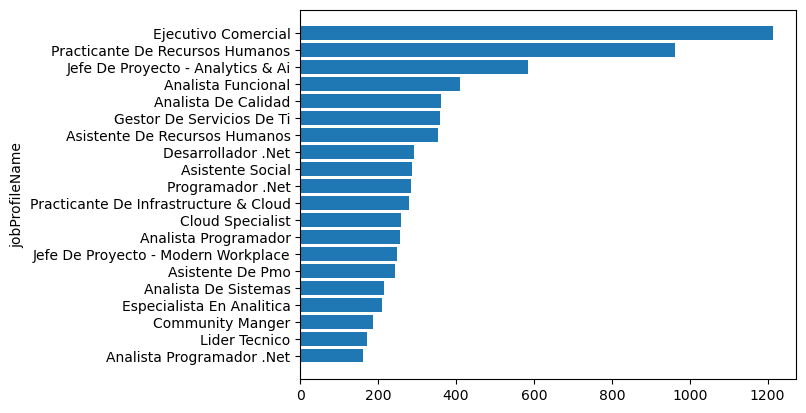

Peru                    10042
Venezuela                 146
Argentina                  11
Colombia                    9
Brasil                      4
Ecuador                     3
Chile                       2
Republica Dominicana        2
Espana                      1
Panama                      1
Bolivia                     1
El Salvador                 1
Costa Rica                  1
Francia                     1
Name: candidateResidenceCountry, dtype: int64


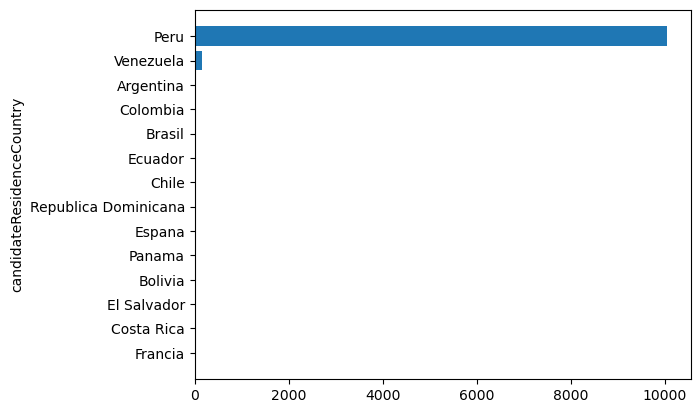

Soltero/A          8330
Casado/A           1591
Divorciado/A        137
Pareja De Hecho     115
Union Libre          49
Viudo/A               3
Name: candidateCivilStatus, dtype: int64


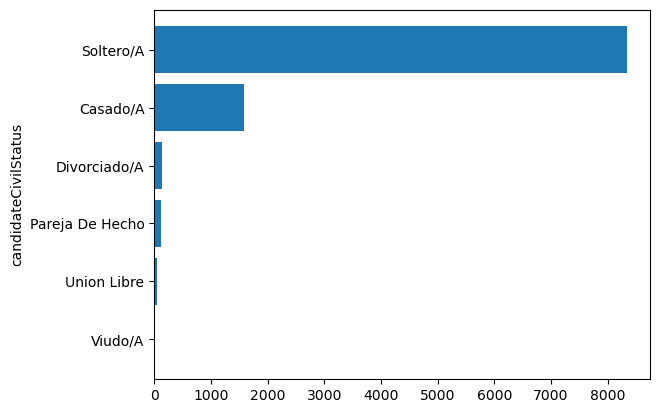

Peru                    10040
Venezuela                 148
Argentina                  11
Colombia                    9
Brasil                      4
Ecuador                     3
Chile                       2
Republica Dominicana        2
Espana                      1
Panama                      1
Bolivia                     1
El Salvador                 1
Costa Rica                  1
Francia                     1
Name: candidateBirthCountry, dtype: int64


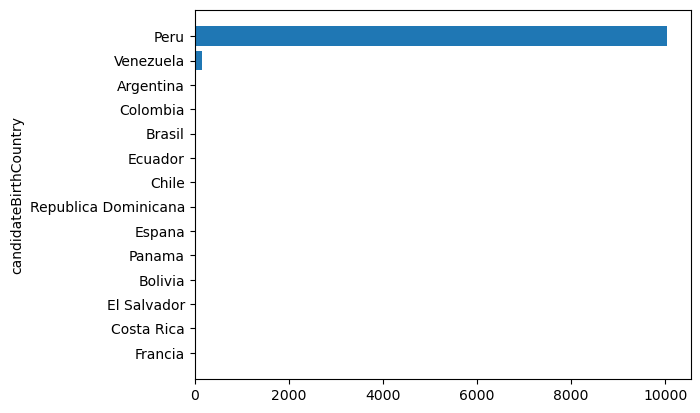

2500.0    617
5000.0    617
2000.0    588
3500.0    562
3000.0    549
4000.0    532
1500.0    472
6000.0    438
4304.8    424
4500.0    405
1200.0    362
1800.0    354
5500.0    302
1025.0    298
7000.0    283
1000.0    282
6500.0    281
930.0     227
8000.0    202
1.0       201
Name: salary, dtype: int64


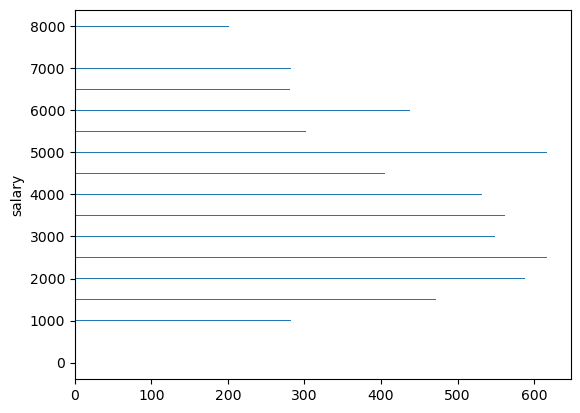

Freelance                                          215
Ntt Data Peru S.A.C.                               179
Canvia S.A.C.                                      166
Mdp Consulting S.A.C.                              115
Global Hitss Peru S.A.C.                           114
Manpower Professional Services S.A.                110
Indra Peru S.A.                                     93
Telefonica Del Peru                                 90
Banco De Credito Del Peru - Bcp                     85
Stefanini It Solutions                              74
Corporacion Sapia S.A.                              56
Tata Consultancy Services                           55
Universidad Peruana De Ciencias Aplicadas (Upc)     44
Ferreyros S.A.                                      44
Oficina Nacional De Procesos Electorales (Onpe)     41
Tgestiona Sac                                       41
Gfi Peru Sac                                        40
America Movil Peru S.A.C.                           40
Ibm Del Pe

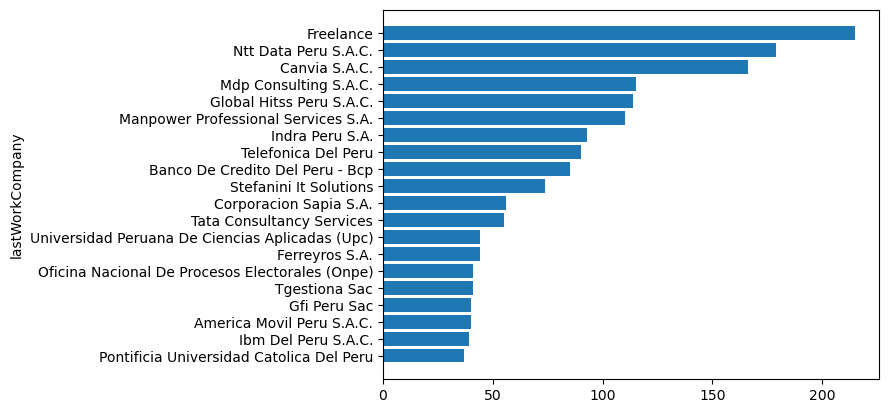

Peru              10041
Estados Unidos       32
Venezuela            27
Espana               25
Colombia             17
Brasil               16
Chile                13
Argentina             9
Ecuador               7
Mexico                4
Albania               3
Costa Rica            3
Reino Unido           3
Australia             3
Panama                2
Italia                2
Francia               2
Finlandia             2
Paises Bajos          2
Guatemala             1
Name: lastWorkCountry, dtype: int64


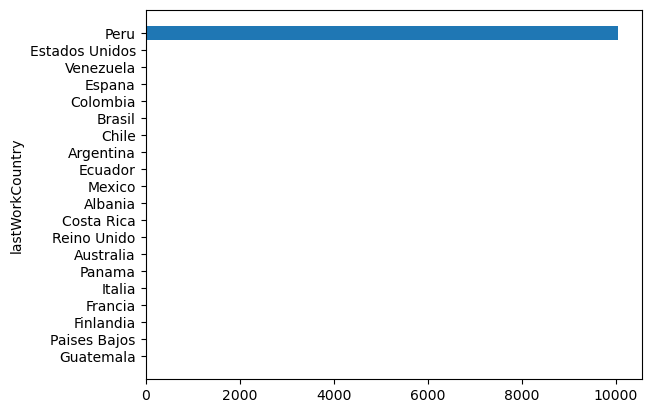

Tecnologia / Sistemas            1108
Tecnologias De La Informacion    1093
Programacion                      618
Liderazgo De Proyecto             616
Comercial                         587
Sistemas                          512
Recursos Humanos                  468
Ventas                            284
Administracion                    276
Analisis De Datos                 249
Analisis Funcional                232
Infraestructura                   226
Soporte Tecnico                   211
Atencion Al Cliente               175
Seguridad Informatica             168
Otras Ingenierias                 157
Testing / Qa / Qc                 135
Desarrollo De Negocios            134
Telecomunicaciones                127
Administracion De Personal        119
Name: lastWorkArea, dtype: int64


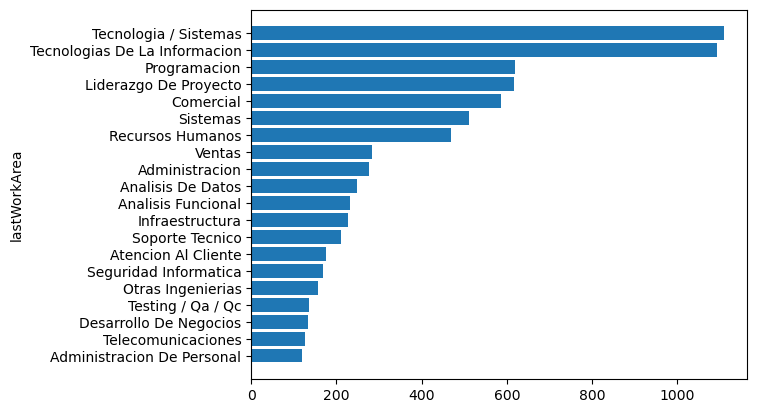

Analista Programador                            564
Analista De Sistemas                            269
Jefe De Proyectos                               184
Analista Funcional                              162
Asistente Administrativo                        109
Trabajadora Social                              108
Analista De Calidad                             106
Ejecutivo Comercial                              99
Asistente De Recursos Humanos                    92
Supervisor De Infraestructura De Redes Cisco     86
Project Manager                                  73
Asesor Comercial                                 71
Lider Tecnico                                    64
Gerente De Proyectos                             61
Soporte Tecnico                                  59
Practicante De Recursos Humanos                  57
Practicante                                      56
Analista Desarrollador                           52
Analista                                         50
Gestor De Pr

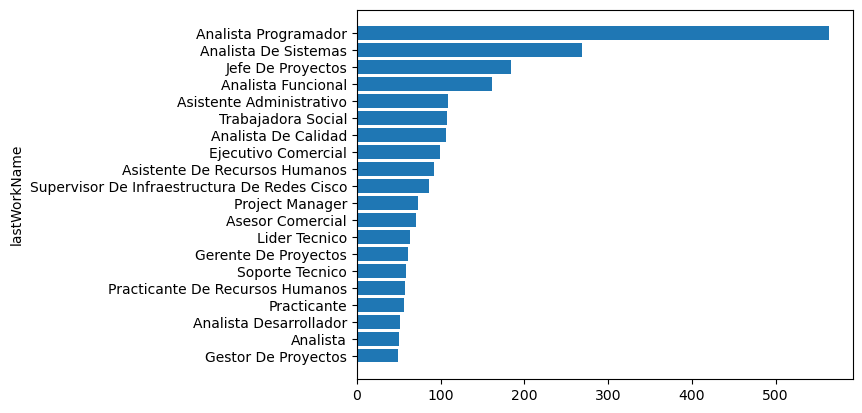

5.0     1300
4.0     1184
6.0     1059
3.0     1021
7.0      935
2.0      740
8.0      735
1.0      663
6.1      562
9.0      530
10.0     407
11.0     274
12.0     238
13.0     152
14.0     119
15.0      91
17.0      60
16.0      45
19.0      37
18.0      30
Name: worksNumber, dtype: int64


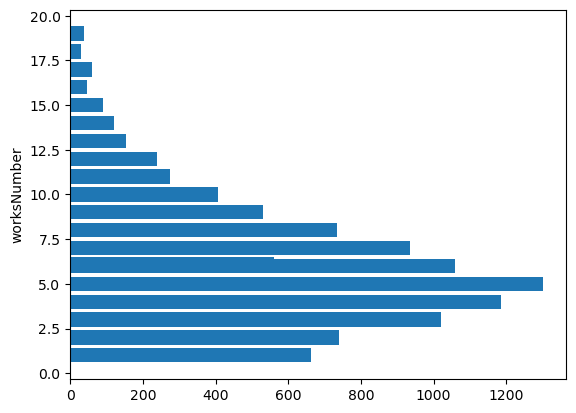

Universidad Peruana De Ciencias Aplicadas    920
Universidad Tecnologica Del Peru             524
Instituto Cibertec                           441
Pontificia Universidad Catolica Del Peru     349
Universidad Privada Del Norte                349
Universidad San Ignacio Del Loyola           329
Universidad Nacional Mayor De San Marcos     328
Universidad Cesar Vallejo                    299
Universidad Esan                             290
Universidad De Lima                          246
Universidad De San Martin De Porres          221
Universidad Nacional De Ingenieria           218
Instituto San Ignacio De Loyola              190
Universidad Nacional Federico Villarreal     189
Universidad Ricardo Palma                    186
Universidad Inca Garcilaso De La Vega        178
Tecsup                                       125
Instituto Superior Tecnologico Idat          119
Universidad Del Pacifico                     107
Universidad Nacional Del Callao              104
Name: lastEducationC

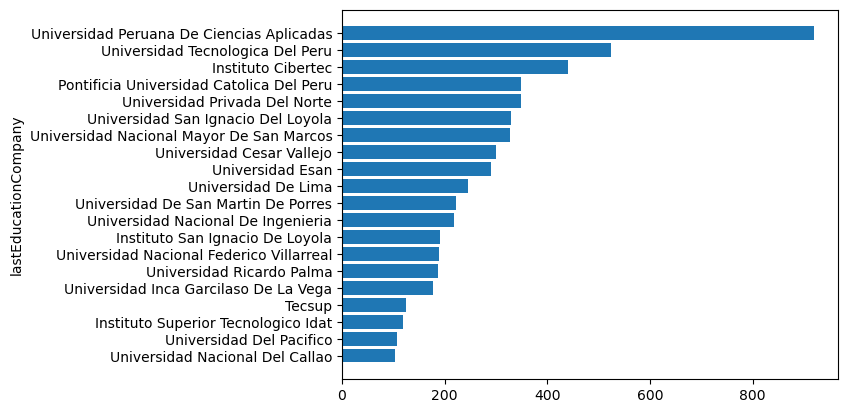

Peru              9602
Espana             202
Venezuela          163
Estados Unidos      79
Mexico              34
Argentina           20
Colombia            19
Chile               19
Brasil              19
Costa Rica          14
Canada               8
Australia            6
Bolivia              6
Ecuador              6
Francia              5
Alemania             3
India                3
Reino Unido          3
Internacional        2
Cuba                 2
Name: lastEducationCountry, dtype: int64


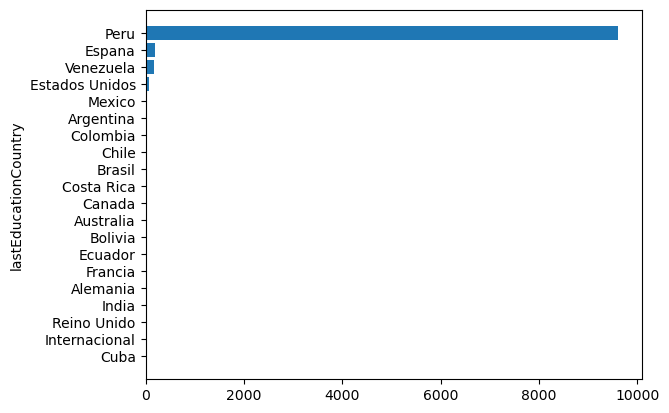

Ing. En Sistemas                  2352
Tecnologias De La Informacion     1264
Adm. De Empresas                  1159
Ing. Informatica                   635
Ing. Industrial                    493
Computacion / Informatica          489
Marketing / Comercializacion       375
Recursos Humanos / Relac. Ind.     358
Psicologia                         355
Otra                               347
Ing. - Otros                       193
Trabajo Social                     144
Analisis De Sistemas               140
Ing. Telecomunicaciones            134
Programacion                       123
Telecomunicaciones                 120
Procesos / Calidad Total           106
Finanzas                            95
Bachiller                           93
Ing. Electronica                    90
Name: lastEducationArea, dtype: int64


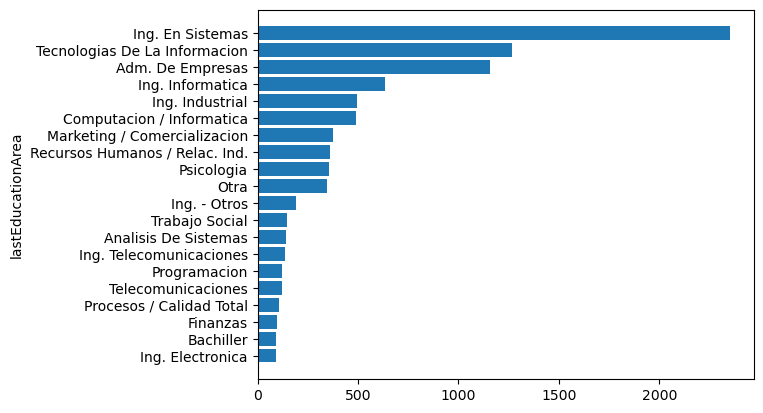

Ingenieria De Sistemas                       1614
Ingenieria Industrial                         338
Psicologia                                    315
Administracion De Empresas                    233
Computacion E Informatica                     182
Bachiller En Ingenieria De Sistemas           132
Mba                                           131
Administracion                                129
Marketing                                     123
Administracion Y Negocios Internacionales      95
Ingles                                         85
Gestion De Proyectos                           75
Scrum Master                                   75
Itil                                           75
Trabajo Social                                 70
Ingenieria Informatica                         63
Ingenieria De Redes Y Comunicaciones           62
Ingenieria De Software                         57
Tecnico En Computacion E Informatica           57
Ingenieria De Computacion Y Sistemas           51


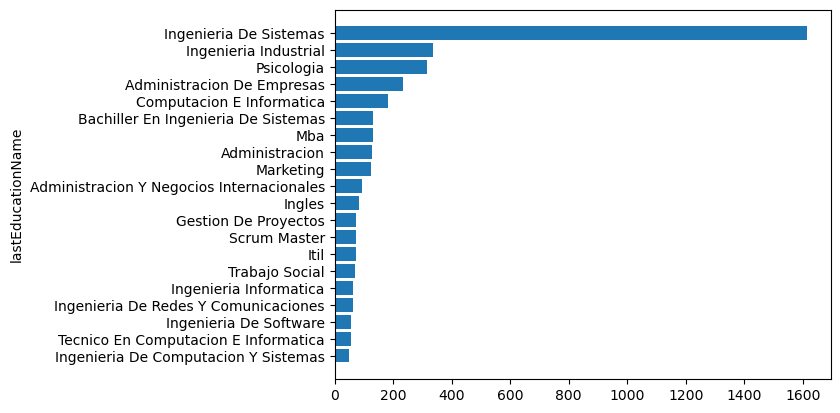

Graduado      6685
En Curso      3367
Abandonado     173
Name: lastEducationStatus, dtype: int64


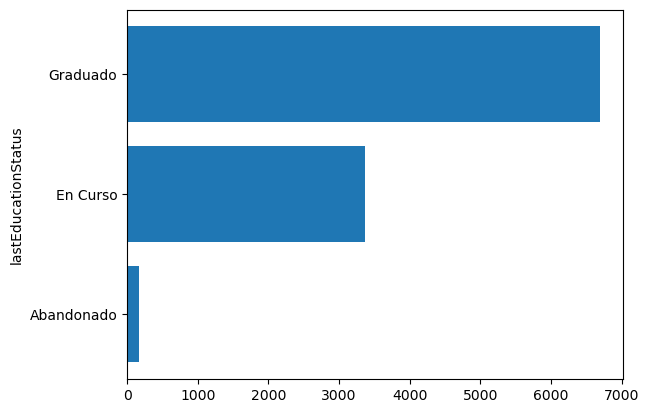

Universitario        5068
Otro                 2308
Posgrado             1190
Terciario/Tecnico    1026
Master                607
Doctorado              14
Secundario             12
Name: lastEducationDegree, dtype: int64


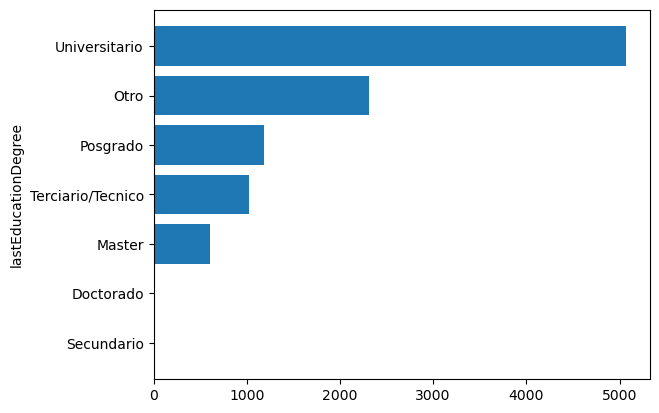

1.0     3820
2.0     2349
3.0     1166
4.0      711
5.0      471
6.0      427
7.0      283
8.0      191
9.0      142
3.2      123
11.0     117
10.0      90
12.0      69
14.0      53
13.0      44
16.0      25
15.0      22
20.0      19
18.0      18
17.0      17
Name: studiesNumber, dtype: int64


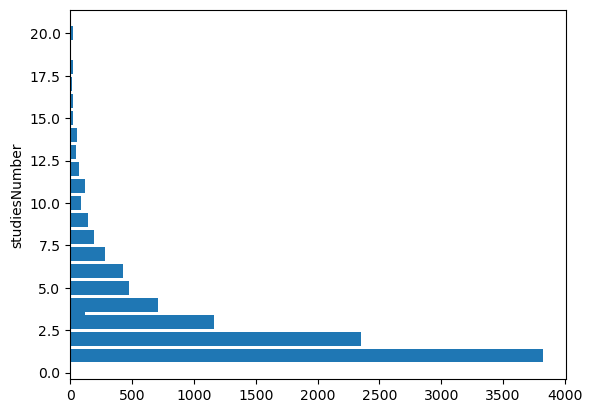

9.3     1220
1.0     1122
3.0      863
2.0      808
4.0      685
5.0      586
6.0      526
7.0      486
9.0      448
8.0      420
11.0     341
10.0     336
12.0     258
13.0     240
16.0     231
14.0     184
15.0     160
17.0     126
18.0     119
21.0      92
Name: technicalSkills, dtype: int64


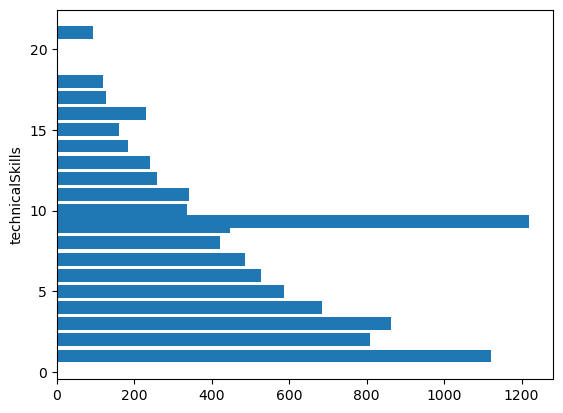

1.0    7122
2.0    1973
1.3     772
3.0     302
4.0      55
5.0       1
Name: languages, dtype: int64


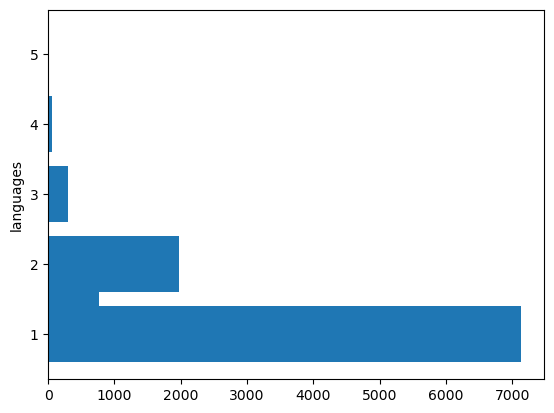

5.3     2372
1.0     1752
2.0     1171
3.0      835
4.0      743
5.0      635
6.0      494
7.0      430
8.0      342
9.0      274
10.0     215
11.0     174
12.0     139
13.0     115
14.0      89
15.0      69
17.0      50
16.0      49
20.0      36
19.0      32
Name: otherSkills, dtype: int64


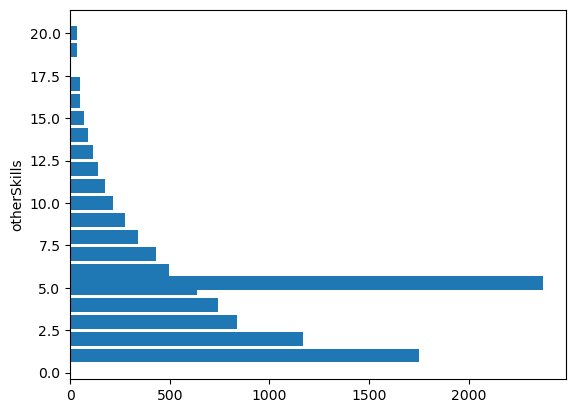

0    9722
1     503
Name: hired, dtype: int64


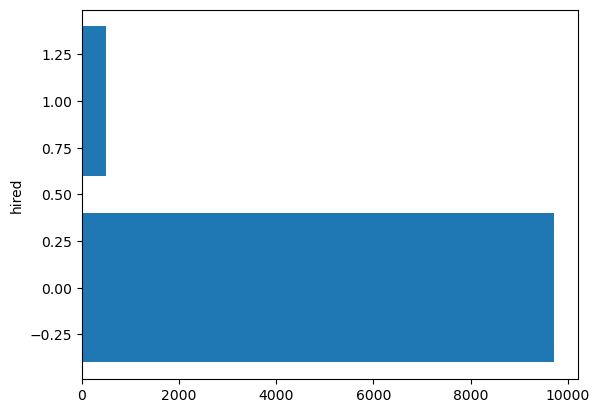

Fin: 2023-05-22 10:35:28.760407
Tiempo: 0:00:11.815788


In [77]:
if __name__ == "__main__":
  main()